- g(t) - целевое состояние среды в момент t (в данном случае функция Хевисайда)
- x(t) - состояние среды в момент t (вектор производных от 0 до n)
- u(t) - действие агента в ответ на изменение среды,
$u(t)=k*(g(t-\tau)-x(t-\tau))$
- $\tau$ - запаздывание агента


In [244]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


T = 1000 # Время моделирования
dt = 0.01  # Шаг по времени
N_max = int(T / dt)  # Максимальное количество шагов
N_min = 10 # Максимальное количество шагов

epsilon = 1e-6  # Порог сходимости

data = []

def simulate(a, b, c, k, tau):
    # Параметры уравнения
    # a = 1  # Коэффициент при второй производной
    # b = 1  # Коэффициент при первой производной
    # c = 100  # Коэффициент при функции x

    # k = 100
    # tau = 2 # количество шагов запаздывания
    
    x = [0, 0]
    g = lambda t: 1 if t > 0 else 0

    def get_x(t):
        if t <= 0:
            return x[0]
        return x[t+1]

    u = lambda t: k*(g(dt*(t-tau))-get_x(t-tau))  # Правая часть уравнения

    t = 1

    while (abs(np.std(x[-int(len(x)*0.2):])) > epsilon or t < max(tau+2, N_min)) and t < N_max - 1:

        # x[n+1] = ((a * x[n] + dt * u(n)) / (a + dt))
        x.append((2 * a * x[-1] - (a - b * dt / 2) * x[-2] + dt**2 * (u(t) - c * x[-1])) / (a + b * dt / 2))
        t += 1
    
    return x, t

def show(x, t, a, b, c, k, tau):
    plt.figure(figsize=(8,5))
    plt.plot(np.linspace(0,int(t*dt),t-1), x[2:], label=f"tau={tau*dt:.2f}, k={k}, \
            \na,b,c=({a:.2f}, {b:.2f}, {c:.2f}) \nx(t)={x[-1]:.2f}\nвремя: {t*dt:.2f}/{T}")
    plt.xlabel('t')
    plt.ylabel('x(t)')
    plt.grid(True)
    plt.legend()
    plt.show()

temp = [0.5, 1, 2, 5, 10]
for a in temp:
    for b in temp:
        for c in temp:
            for k in temp:
                for tau in range(2, 5):
                    x, t = simulate(a,b,c,k,tau)
                    data.append((a,b,c,k,tau,np.std(x[-int(len(x)*0.1):]), x[-1], t*dt/T))

    # show(x,t,c,1,c,1,2)


In [246]:

df = pd.DataFrame(data, columns=['a', 'b', 'c', 'k', 'tau', 'std(x[-10%:])', 'x[-1]', 't/T'])

In [289]:
df['converged'] = df['t/T'].apply(lambda x: int(x<0.9))
# df.groupby('a')['t/T'].mean()

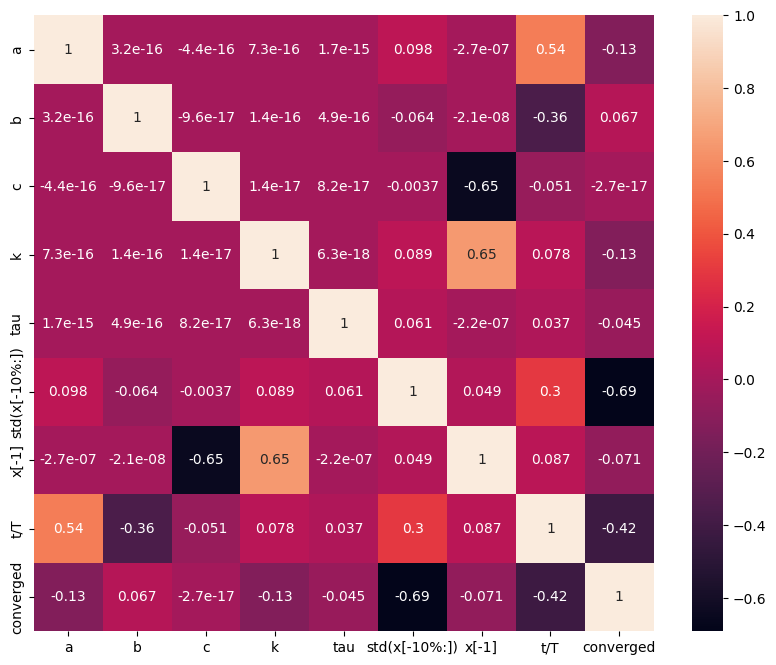

In [290]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt='.2g')
plt.show()

In [307]:
df.groupby('c')[['x[-1]', 't/T']].mean()

,x[-1],t/T
c,,
0.5,0.765628,0.112943
1.0,0.648485,0.106393
2.0,0.516190,0.100158
5.0,0.341991,0.093102
10.0,0.227706,0.088397


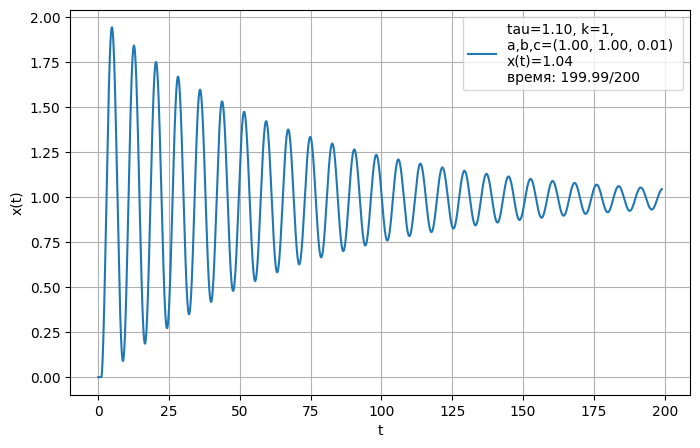

In [487]:
T = 200
N_max = int(T / dt)
x, t = simulate(1,1,0.01,1,110)
show(x,t,1,1,0.01,1,110)

Система становится неустойчивой при tau = 1.4285714285714286
Критическое значение tau для устойчивости: 1.3265306122448979


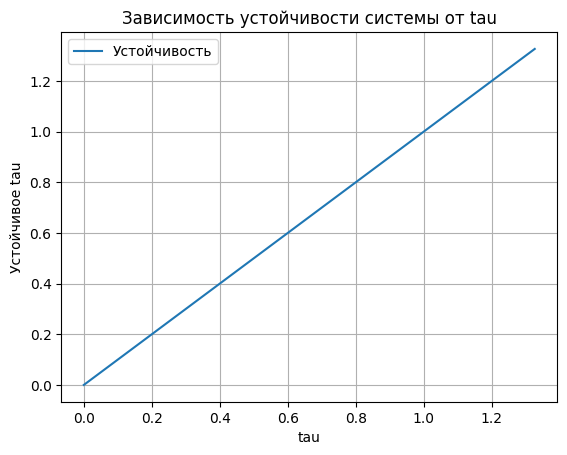

In [211]:
import numpy as np
import matplotlib.pyplot as plt

# Параметры уравнения
a = 1.0  # Коэффициент при второй производной
b = 0.5  # Коэффициент при первой производной
c = 1.0  # Коэффициент при функции y
k = 2.0  # Степень воздействия агента
g = lambda t: 1 if t >= 0 else 0  # Функция Хевисайда

# Параметры временной сетки
T = 10  # Время моделирования
dt = 0.01  # Шаг по времени
N = int(T / dt)  # Количество шагов

# Начальные условия
y0 = 0.0  # y(0)
y1 = 0.1  # y'(0)

# Порог устойчивости
threshold = 10  # Ограничение для амплитуды решения

def simulate_system(tau):
    tau_steps = int(tau / dt)  # Количество шагов, соответствующее запаздыванию
    
    # Массивы для хранения решения
    y = np.zeros(N)
    t = np.linspace(0, T, N)

    # Задание начальных условий
    y[0] = y0
    y[1] = y0 + y1 * dt  # Используем приближение для начальных условий

    # Основной цикл по времени
    for n in range(1, N - 1):
        # Индекс для запаздывающего значения
        if n >= tau_steps:
            y_tau = y[n - tau_steps]
        else:
            y_tau = 0  # Для начала моделирования, когда нет значений до tau

        # Неоднородность с учётом запаздывания
        f_n = k * (g(t[n] - tau) - y_tau)

        # Разностная схема с учётом воздействия агента
        y[n+1] = ((2 * a * y[n] - (a - b * dt / 2) * y[n-1] +
                   dt**2 * (f_n - c * y[n])) /
                  (a + b * dt / 2))

        # Проверка на устойчивость: если амплитуда слишком велика, считаем неустойчивым
        if abs(y[n+1]) > threshold:
            return False, y  # Система неустойчива

    return True, y  # Система устойчива

# Поиск граничного значения tau
taus = np.linspace(0, 5, 50)  # Интервал значений tau для анализа
stable_taus = []

for tau in taus:
    stable, y = simulate_system(tau)
    if stable:
        stable_taus.append(tau)
    else:
        print(f"Система становится неустойчивой при tau = {tau}")
        break  # Выходим, когда находим критическое значение tau

# Вывод граничного значения tau
if stable_taus:
    critical_tau = stable_taus[-1]
    print(f"Критическое значение tau для устойчивости: {critical_tau}")

# Визуализация результатов
plt.plot(taus[:len(stable_taus)], stable_taus, label='Устойчивость')
plt.xlabel('tau')
plt.ylabel('Устойчивое tau')
plt.title('Зависимость устойчивости системы от tau')
plt.grid(True)
plt.legend()
plt.show()
